**Table of contents**<a id='toc0_'></a>    
- [Data Mining Lab 2 - Phase 2](#toc1_)    
  - [Before Starting](#toc1_1_)    
  - [Introduction](#toc1_2_)    
  - [**1. Data Preparation**](#toc1_3_)    
  - [**1.1 Load data**](#toc1_4_)    
    - [**1.2 Save data**](#toc1_4_1_)    
  - [**2. Large Language Models (LLMs)**](#toc1_5_)    
    - [Open-Source vs. Proprietary LLMs](#toc1_5_1_)    
    - [Why Use Code (API) for Data Mining?](#toc1_5_2_)    
    - [The Gemini API](#toc1_5_3_)    
    - [Interacting with the Gemini API](#toc1_5_4_)    
    - [**2.1 Text Prompting**](#toc1_5_5_)    
        - [**>>> Exercise 1 (Take home):**](#toc1_5_5_1_1_)    
    - [**2.2 Structured Output**](#toc1_5_6_)    
        - [**>>> Exercise 2 (Take home):**](#toc1_5_6_1_1_)    
    - [**2.3 Information Extraction and Grounding:**](#toc1_5_7_)    
      - [**`langextract`: A Library for Grounded Extraction**](#toc1_5_7_1_)    
        - [**2.3.1 Using PDF Documents:**](#toc1_5_7_1_1_)    
        - [**>>> Bonus Exercise 3 (Take home):**](#toc1_5_7_1_2_)    
    - [**2.4 Generating LLM Embeddings:**](#toc1_5_8_)    
        - [**>>> Exercise 4 (Take home):**](#toc1_5_8_1_1_)    
    - [**2.5 Retrieval-Augmented Generation (RAG)**](#toc1_5_9_)    
        - [**Actual answer in the URL:**](#toc1_5_9_1_1_)    
        - [**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc1_5_9_1_2_)    
        - [**>>> Bonus Exercise 5 (Take home):**](#toc1_5_9_1_3_)    
    - [**2.6 Few-Shot Prompting Classification:**](#toc1_5_10_)    
        - [**>>> Exercise 6 (Take home):**](#toc1_5_10_1_1_)    
        - [**>>> Exercise 7 (Take home):**](#toc1_5_10_1_2_)    
    - [**2.7 Extra LLM Related Materials:**](#toc1_5_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Data Mining Lab 2 - Phase 2](#toc0_)
In this lab's phase 2 session we will focus on exploring some basic LLMs' applications with data.


## <a id='toc1_1_'></a>[Before Starting](#toc0_)

**Make sure you have installed all the required libraries and you have the environment ready to run this lab.**
    

In [2]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')
bool(api_key)

True

In [3]:
# 程式需從環境變數讀取
import os
if api_key:
    os.environ["GOOGLE_API_KEY"] = api_key

---
## <a id='toc1_2_'></a>[Introduction](#toc0_)

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embeddings and other deep information retrieval approaches.

![pic0.png](./pics/pic0.png)

---
## <a id='toc1_3_'></a>[**1. Data Preparation**](#toc0_)

---
## <a id='toc1_4_'></a>[**1.1 Load data**](#toc0_)

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [4]:
# 從 Github 一鍵下載 + 導入到專案資料夾
REPO_URL  = "https://github.com/LukaChien/DM2025-Lab2-Exercise.git"
REPO_NAME = "DM2025-Lab2-Exercise"

import pathlib
if not pathlib.Path(REPO_NAME).exists():
    !git clone {REPO_URL}

%cd {REPO_NAME}

# 檢查目前位置與檔案是否還存在
from pathlib import Path
print("CWD:", Path.cwd())
base = Path("data/semeval/train")
for fn in [
    "anger-ratings-0to1.train.txt",
    "sadness-ratings-0to1.train.txt",
    "fear-ratings-0to1.train.txt",
    "joy-ratings-0to1.train.txt",
]:
    p = base / fn
    print(p, "->", p.exists())


/content/DM2025-Lab2-Exercise
CWD: /content/DM2025-Lab2-Exercise
data/semeval/train/anger-ratings-0to1.train.txt -> True
data/semeval/train/sadness-ratings-0to1.train.txt -> True
data/semeval/train/fear-ratings-0to1.train.txt -> True
data/semeval/train/joy-ratings-0to1.train.txt -> True


In [5]:
import pandas as pd
cols = ["id","text","emotion","intensity"]

anger_train  = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",   sep="\t", header=None, names=cols)
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",  sep="\t", header=None, names=cols)
fear_train   = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",   sep="\t", header=None, names=cols)
joy_train   = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",    sep="\t", header=None, names=cols)

anger_train.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [6]:
import pandas as pd

# --- training data ---
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [7]:
# 結合 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [8]:
# --- testing data ---
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [9]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [10]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### <a id='toc1_4_1_'></a>[**1.2 Save data**](#toc0_)

In [11]:
# save to pickle file
train_df.to_pickle("./data/train_df.pkl")
test_df.to_pickle("./data/test_df.pkl")

In [12]:
import pandas as pd

# load a pickle file
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
## <a id='toc1_5_'></a>[**2. Large Language Models (LLMs)**](#toc0_)

Before we start we strongly suggest that you watch the following video explanations so you can understand the concepts that we are gonna discuss about LLMs:

1. [How Large Language Models Work](https://www.youtube.com/watch?v=5sLYAQS9sWQ)
2. [Large Language Models explained briefly](https://www.youtube.com/watch?v=LPZh9BOjkQs)
3. [What is Prompt Tuning?](https://www.youtube.com/watch?v=yu27PWzJI_Y)
4. [Why Large Language Models Hallucinate](https://www.youtube.com/watch?v=cfqtFvWOfg0)
5. [What are LLM Embeddings?](https://www.youtube.com/watch?v=UShw_1NbpCw&t=182s)
6. [What is Retrieval-Augmented Generation (RAG)?](https://www.youtube.com/watch?v=T-D1OfcDW1M)
7. [RAG vs Fine-Tuning vs Prompt Engineering: Optimizing AI Models](https://www.youtube.com/watch?v=zYGDpG-pTho)
8. [Discover Few-Shot Prompting | Google AI Essentials](https://www.youtube.com/watch?v=9qdgEBVkWR4)
9. [What is Zero-Shot Learning?](https://www.youtube.com/watch?v=pVpr4GYLzAo)
10. [Zero-shot, One-shot and Few-shot Prompting Explained | Prompt Engineering 101](https://www.youtube.com/watch?v=sW5xoicq5TY)

`These videos can help you get a better grasp on the core concepts of LLMs if you were not familiar before.`

**So now let's start with the main content of Lab 2 Phase 2.**

Large Language Models (LLMs) are AI systems trained on vast amounts of text to understand and generate human language for tasks like summarization and translation.

### <a id='toc1_5_1_'></a>[Open-Source vs. Proprietary LLMs](#toc0_)
*   **Open-Source Models** (e.g., Llama, Gemma) are customizable and cost-effective but require technical skill to manage and may be less powerful.
*   **Proprietary Models** (e.g., Gemini, ChatGPT) offer top performance and ease of use but are more costly and less flexible.

For students interested in running models locally, the optional notebook `DM2025-Lab2-Optional-Ollama.ipynb` explores using Ollama ([Ollama GitHub Link](https://github.com/ollama/ollama)). It needs a capable GPU to run models (**at least 4GB VRAM**).

You can explore the variety of models available through Ollama here:

![pic10.png](./pics/pic10.png)

### <a id='toc1_5_2_'></a>[Why Use Code (API) for Data Mining?](#toc0_)

For data analysis, accessing LLMs programmatically is superior to using web chatbots because it allows for:
*   **Automation:** Easily process entire datasets with loops.
*   **Structured Output:** Receive data in usable formats like **JSON**, ready for analysis in tools like pandas.
*   **Reproducibility:** Ensure consistent results by setting fixed parameters.
*   **Privacy:** Maintain data security, especially when running models locally.

For the main exercises in this lab, we will use **the Gemini API**. This approach offers several advantages over running local open-source models, such as access to state-of-the-art model performance without needing specialized hardware. While the API has usage limits (rate limits and token quotas), it provides a generous **free tier** that is more than sufficient for our exercises.

![pic13.png](./pics/pic13.png)

![pic14.png](./pics/pic14.png)

### <a id='toc1_5_3_'></a>[The Gemini API](#toc0_)

We will primarily use the **Gemini 2.5 Flash-Lite** (`gemini-2.5-flash-lite`) model. As shown in the rate limit table, this model is optimized for high-frequency tasks and offers a high request-per-day limit of 1,000, making it ideal for completing the lab exercises without interruption.

Students are encouraged to explore other models available through the API but should remain mindful of their respective usage limits. For instance:
*   **Gemini 2.5 Pro** is a more powerful model but has a lower daily request limit of 100.
*   The **Gemma 3** model available via the API offers an impressive 14,400 requests per day, providing another excellent alternative for experimentation.

Please be aware of your usage limits as you work through the exercises to ensure you do not get rate-limited.

[Gemini Documentation](https://ai.google.dev/gemini-api/docs)

[Gemini Rate Limits](https://ai.google.dev/gemini-api/docs/rate-limits)

[Description of Gemini Models](https://ai.google.dev/gemini-api/docs/models)

---

### <a id='toc1_5_4_'></a>[Interacting with the Gemini API](#toc0_)

The code cell below contains the primary function, `prompt_gemini`, that we will use throughout this lab to communicate with the Gemini API. It's designed to be a flexible wrapper that handles the details of sending a request and receiving a response.

Before you run the exercises, here are the key things you need to understand in this setup:

*   **API Key Configuration**: The script loads your API key from a `.env` file located in the `./config/` directory. **You must create this file and add your API key** like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`. This is a security best practice to keep your credentials out of the code.

*   **Global Settings**: At the top of the script, you can find and modify several important defaults:
    *   `MODEL_NAME`: We've set this to `"gemini-2.5-flash-lite"`, but you can easily switch to other models like `"gemini-2.5-pro"` to experiment.
    *   `SYSTEM_INSTRUCTION`: This sets the model's default behavior or persona (e.g., "You are a helpful assistant"). You can customize this for different tasks.
    *   `SAFETY_SETTINGS`: For our academic exercises, these are turned off to prevent interference. In real-world applications, you would configure these carefully.

*   **The `prompt_gemini` function**: This is the main tool you will use. Here are its most important parameters:
    *   `input_prompt`: The list of contents (text, images, etc.) you want to send to the model.
    *   `temperature`: Controls the randomness of the output. `0.0` makes the output deterministic and less creative, while a higher value (e.g., `0.7`) makes it more varied.
    *   `schema`: A powerful feature that allows you to specify a JSON format for the model's output. This is extremely useful for structured data extraction.
    *   `with_tokens_info`: If set to `True`, the function will also return the number of input and output tokens used, which is helpful for monitoring your usage against the free tier limits.

In the following exercises, you will call this function with different prompts and configurations to solve various tasks.

If needed, you can also check some tutorials on how a python function works: [Python Functions Tutorial](https://realpython.com/defining-your-own-python-function/)

In [13]:
import os
from dotenv import load_dotenv
from google import genai
from google.genai import types

env_path = "./config/.env"
load_dotenv(dotenv_path=env_path)

# System instruction that can dictate how the model behaves in the output, can be customized as needed
SYSTEM_INSTRUCTION = (
        "You are a helpful assistant"
    )

# Max amount of tokens that the model can output, the Gemini 2.5 Models have this maximum amount
# For other models need to check their documentation
MAX_OUTPUT_TOKENS = 65535
MODEL_NAME = "gemini-2.5-flash-lite" # Other models: "gemini-2.5-pro", "gemini-2.5-flash"; Check different max output tokens: "gemini-2.0-flash" , "gemini-2.0-flash-lite"

# We disable the safety settings, as no moderation is needed in our tasks
SAFETY_SETTINGS = [
    types.SafetySetting(
        category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_HARASSMENT", threshold="OFF")
]

#IMPORTANT: The script loads your API key from a `.env` file located in the `./config/` directory.
# You must create this file and add your API key like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`

# We input the API Key to be able to use the Gemini models
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key
client = genai.Client(api_key=api_key)

# We also set LangExtract to use the API key as well:
if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = api_key

def prompt_gemini(
        input_prompt: list,
        schema = None,
        temperature: float = 0.0,
        system_instruction: str = SYSTEM_INSTRUCTION,
        max_output_tokens: int = MAX_OUTPUT_TOKENS,
        client: genai.Client = client,
        model_name: str = MODEL_NAME,
        new_config: types.GenerateContentConfig = None,
        with_tools: bool = False,
        with_parts: bool = False,
        with_tokens_info: bool = False
    ):
        try:
            # If we need a JSON schema we set up the following
            if schema:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    response_mime_type="application/json",
                    response_schema=schema,
                    safety_settings=SAFETY_SETTINGS
                )
            # If there is no need we leave it unstructured
            else:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    safety_settings=SAFETY_SETTINGS
                )

            # We add a different custom configuration if we need it
            if new_config:
                generate_content_config = new_config

            # For some tasks we need a more specific way to add the contents when prompting the model
            # So we need custom parts for it sometimes from the "types" objects
            if with_parts:
                response = client.models.generate_content(
                    model=model_name,
                    contents=types.Content(parts=input_prompt),
                    config=generate_content_config,
                )
            # In the simplest form the contents can be expressed as a list [] of simple objects like str and Pillow images
            else:
                response = client.models.generate_content(
                    model=model_name,
                    contents=input_prompt,
                    config=generate_content_config,
                )

            if with_tools:
                # print(response)
                # Include raw response when function calling
                completion = response
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    return completion, log
                return completion
            else:
                completion = response.text
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    # Return the text response and logs (if selected)
                    return completion, log
                return completion
        except Exception as e:
             print(f"Error occurred when generating response, error: {e}")
             return None

---
### <a id='toc1_5_5_'></a>[**2.1 Text Prompting**](#toc0_)

In the same way as with ChatGPT we can use the Gemini models to ask about anything. Here we are going to ask a question requesting the response to be in markdown format, this is to make it have a better display afterwards.

就像在 ChatGPT 一樣，我們也可以用 Gemini 模型來詢問任何問題。接下來我們會發出一個問題，並要求回覆採用 Markdown 格式，這樣之後的顯示效果會更好。

For more information visit:
[Gemini's Text Generation Documentation](https://ai.google.dev/gemini-api/docs/text-generation)

In [14]:
input_prompt = ["What is Data Mining?"]
text_response, logs = prompt_gemini(input_prompt = input_prompt, with_tokens_info = True)
print(text_response)

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strat

We can also check the logs of the usage with our model that we defined in our previous function. We can observe the model we used, how many tokens where in the prompt in the input, and the output text response tokens of our model.

我們也可以查看先前函式所定義那個模型的使用紀錄（logs）。從這些紀錄中，可以看到：使用的是**哪個模型、輸入提示（prompt）的token 數、以及模型產生的輸出文字的 token 數**。

In [15]:
print(logs)

{'model': 'gemini-2.5-flash-lite', 'input_tokens': 12, 'output_tokens': 911}


**We can use the IPython library to make the response look better:**

In [16]:
from IPython.display import display, Markdown
display(Markdown(text_response))

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strategic planning.

**How it Works (The Process):**

Data mining is usually an iterative process that involves several stages:

1.  **Business Understanding:** Defining the problem or objective you want to achieve with data mining. What questions are you trying to answer? What business goals are you trying to meet?
2.  **Data Understanding:** Exploring and getting familiar with the data. This involves collecting, cleaning, and understanding the data's structure, quality, and meaning.
3.  **Data Preparation (Preprocessing):** This is often the most time-consuming stage. It involves:
    *   **Cleaning:** Handling missing values, noisy data, and inconsistencies.
    *   **Integration:** Combining data from multiple sources.
    *   **Transformation:** Normalizing or aggregating data to make it suitable for mining.
    *   **Reduction:** Reducing the size of the dataset while preserving important information.
4.  **Modeling:** Selecting and applying appropriate data mining techniques (algorithms) to discover patterns. This is where the "mining" happens.
5.  **Evaluation:** Assessing the quality and usefulness of the discovered patterns. Do they make sense? Are they statistically significant? Do they meet the business objectives?
6.  **Deployment:** Putting the discovered knowledge into practice. This could involve integrating it into business processes, creating reports, or building predictive models.

**Common Data Mining Techniques:**

Data mining employs a variety of techniques, often drawing from statistics, machine learning, and database systems. Some of the most common include:

*   **Classification:** Categorizing data into predefined classes (e.g., predicting whether a customer will churn or not).
*   **Clustering:** Grouping similar data points together without predefined classes (e.g., segmenting customers into different groups based on their purchasing behavior).
*   **Association Rule Mining:** Discovering relationships between items in a dataset (e.g., "customers who buy bread also tend to buy milk"). This is often used in market basket analysis.
*   **Regression:** Predicting a continuous numerical value (e.g., predicting the price of a house based on its features).
*   **Anomaly Detection (Outlier Detection):** Identifying data points that deviate significantly from the norm (e.g., detecting fraudulent transactions).
*   **Sequential Pattern Mining:** Discovering patterns that occur in a sequence over time (e.g., identifying common user navigation paths on a website).

**Why is Data Mining Important?**

Data mining is crucial for businesses and organizations because it enables them to:

*   **Make Better Decisions:** By understanding customer behavior, market trends, and operational efficiencies, organizations can make more informed and strategic decisions.
*   **Improve Customer Relationships:** Identifying customer preferences and predicting their needs allows for personalized marketing, better customer service, and increased loyalty.
*   **Detect Fraud and Risk:** Anomaly detection can help identify fraudulent activities, security breaches, and potential risks.
*   **Optimize Operations:** Understanding patterns in operational data can lead to improved efficiency, reduced costs, and better resource allocation.
*   **Drive Innovation:** Discovering new insights can spark new product development, service offerings, and business models.
*   **Gain a Competitive Advantage:** Organizations that effectively leverage data mining can outperform their competitors by understanding their market and customers better.

In essence, data mining is a powerful tool for transforming raw data into valuable intelligence, driving progress and innovation across various fields.

---
##### <a id='toc1_5_5_1_1_'></a>[**>>> Exercise 1 (Take home):**](#toc0_)

`With your own prompt`, run the previous example in the following way:

1. Run it with the same model as the example (gemini-2.5-flash-lite).
2. Run it with a different gemini model from the available options for the API.
3. Discuss the differences on the results with different models.
4. Discuss what would happen if you change the system prompt.

- 用跟範例一樣的模型（gemini-2.5-flash-lite）執行一次。
- 再用另一個 Gemini 模型（從 API 可用清單中挑一個）執行一次。
- 比較不同模型跑出來的結果差異並討論。
- 討論如果改變 system prompt（系統提示）會發生什麼事。


In [17]:
# Answer here
# EX1: 用兩個不同 Gemini 模型比較差異

!pip -q install -U google-generativeai

import google.generativeai as genai
from google.colab import userdata
from IPython.display import display, Markdown

api_key = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=api_key)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 3.2.0 requires google-ai-generativelanguage<1.0.0,>=0.9.0, but you have google-ai-generativelanguage 0.6.15 which is incompatible.


In [18]:
import google.generativeai as genai
import os

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])  # 目前的讀 key 的方式

for m in genai.list_models():
    # 只列出可以支援 generateContent 的模型
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/learnlm-2.0-flash-experimental
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash

In [19]:
# (1) 先使用與範例相同的模型：gemini-2.5-flash-lite
import google.generativeai as genai
from IPython.display import Markdown

genai.configure(api_key=api_key)

def ask_once(model_name, user_prompt, sys_prompt=None):
    model = genai.GenerativeModel(model_name=model_name,
                                  system_instruction=sys_prompt)
    resp = model.generate_content(user_prompt)
    # 取用量資訊
    usage = getattr(resp, "usage_metadata", None)
    logs = {}
    if usage:
        logs = {
            "model": model_name,
            "input_tokens": getattr(usage, "prompt_token_count", None),
            "output_tokens": getattr(usage, "candidates_token_count", None),
            "total_tokens": getattr(usage, "total_token_count", None),
        }
    return resp.text, logs

sys_prompt = (
    "You are a helpful data mining tutor. "
    "Always answer in clear Markdown with sections and bullet points."
)
user_prompt = "What is Data Mining? Please answer in Markdown."
"""
user_prompt = "Explain **What is Data Mining?**. Answer in Markdown, keep it under 10 bullet points."
sys_prompt  = "You are a concise data-mining TA. Prefer clear bullet points and short definitions."
"""
text_flash, logs_flash = ask_once("models/gemini-2.5-flash-lite", user_prompt, sys_prompt)
print(logs_flash)
Markdown(text_flash)

{'model': 'models/gemini-2.5-flash-lite', 'input_tokens': 30, 'output_tokens': 881, 'total_tokens': 911}


# What is Data Mining?

Data mining is the process of discovering patterns, insights, and knowledge from large datasets. It involves using a combination of techniques from statistics, machine learning, and database systems to extract meaningful information that can be used for decision-making, prediction, and understanding complex phenomena.

## Key Concepts and Goals

*   **Discovery of Patterns:** The core objective is to find hidden, non-obvious, and potentially useful patterns within data. These patterns can reveal relationships, trends, anomalies, or groupings that wouldn't be apparent through simple observation.
*   **Knowledge Extraction:** Data mining aims to transform raw data into actionable knowledge. This knowledge can inform business strategies, scientific research, or personal understanding.
*   **Prediction:** A significant application of data mining is building models that can predict future events or outcomes based on historical data. Examples include predicting customer churn, forecasting sales, or identifying potential fraud.
*   **Description and Summarization:** Data mining can also be used to describe and summarize large datasets, making them more understandable. This might involve segmenting customers into different groups or identifying the most influential factors in a particular outcome.
*   **Scalability:** Data mining techniques are designed to handle very large volumes of data, often far beyond what can be analyzed manually or with traditional statistical methods.

## The Data Mining Process (CRISP-DM Model)

A common framework for data mining is the Cross-Industry Standard Process for Data Mining (CRISP-DM). It outlines a cyclical process:

1.  **Business Understanding:** Define the project objectives and requirements from a business perspective. What problem are we trying to solve? What are the desired outcomes?
2.  **Data Understanding:** Collect and explore the initial data. Understand its content, quality, and structure. Identify potential issues or limitations.
3.  **Data Preparation:** Clean, transform, and format the data for modeling. This is often the most time-consuming phase and can involve handling missing values, removing outliers, feature selection, and data integration.
4.  **Modeling:** Select and apply appropriate data mining techniques (algorithms) to the prepared data. This could involve classification, clustering, regression, association rule mining, etc.
5.  **Evaluation:** Assess the model's performance against the business objectives. Is the model accurate? Does it meet the defined criteria?
6.  **Deployment:** Integrate the discovered knowledge or model into the business or operational system. This could involve creating reports, implementing predictive systems, or making recommendations.

## Common Data Mining Techniques

*   **Classification:** Assigning data points to predefined categories or classes. (e.g., spam detection, medical diagnosis).
*   **Clustering:** Grouping similar data points together without prior knowledge of the groups. (e.g., customer segmentation, document analysis).
*   **Association Rule Mining:** Discovering relationships between items in a dataset, often expressed as "if-then" rules. (e.g., market basket analysis - "customers who buy bread also tend to buy milk").
*   **Regression:** Predicting a continuous numerical value. (e.g., predicting house prices, forecasting stock values).
*   **Anomaly Detection (Outlier Detection):** Identifying data points that deviate significantly from the norm. (e.g., fraud detection, network intrusion detection).
*   **Sequence Mining:** Discovering frequently occurring sequences of events. (e.g., analyzing website clickstreams, identifying patterns in DNA sequences).

## Applications of Data Mining

Data mining has a wide range of applications across various industries:

*   **Business:** Customer relationship management (CRM), targeted marketing, fraud detection, risk management, inventory optimization.
*   **Finance:** Credit scoring, algorithmic trading, fraud detection, customer segmentation.
*   **Healthcare:** Disease prediction, drug discovery, patient risk stratification, personalized medicine.
*   **Retail:** Market basket analysis, recommendation systems, inventory management, customer loyalty programs.
*   **Telecommunications:** Churn prediction, network optimization, fraud detection.
*   **Science and Engineering:** Pattern discovery in scientific experiments, climate modeling, material science.

In essence, data mining is about uncovering valuable hidden treasures within the vast oceans of data we generate today.

In [20]:
# (2) 再使用與範例不同的模型：gemini-2.0-flash-lite-001
text_pro, logs_pro = ask_once("models/gemini-2.0-flash-lite-001", user_prompt, sys_prompt)
print(logs_pro)
Markdown(text_pro)

{'model': 'models/gemini-2.0-flash-lite-001', 'input_tokens': 29, 'output_tokens': 722, 'total_tokens': 751}


Here's a breakdown of what Data Mining is, presented in a clear Markdown format:

## What is Data Mining?

Data mining, also known as knowledge discovery in databases (KDD), is a multidisciplinary field at the intersection of computer science, statistics, machine learning, and database management. It involves automatically extracting meaningful patterns, insights, and knowledge from large datasets.  Think of it as the process of digging through a mountain of data to find valuable nuggets of information.

Here's a more detailed breakdown:

*   **Goal:** To discover hidden patterns, relationships, anomalies, and insights that can be used to make informed decisions, predict future trends, and solve complex problems.

*   **Data Sources:** Data mining can be applied to various data sources, including:
    *   Databases (relational, object-oriented, etc.)
    *   Data warehouses
    *   Transaction data
    *   Web data (e.g., clickstream data, social media data)
    *   Text data
    *   Images and multimedia

*   **Techniques:** Data mining utilizes a variety of techniques, including:
    *   **Classification:** Categorizing data into predefined classes (e.g., spam detection, credit risk assessment).
    *   **Clustering:** Grouping similar data points together (e.g., customer segmentation).
    *   **Association Rule Mining:** Discovering relationships between variables (e.g., market basket analysis: "customers who buy diapers often buy baby formula").
    *   **Regression:** Predicting a continuous value (e.g., predicting sales based on advertising spending).
    *   **Anomaly Detection:** Identifying unusual or outlier data points (e.g., fraud detection).
    *   **Time Series Analysis:** Analyzing data points indexed in time order (e.g., predicting stock prices).

*   **The Data Mining Process:** Generally, data mining involves the following steps:
    1.  **Data Selection:** Choosing the relevant data for the analysis.
    2.  **Data Cleaning:** Handling missing values, noise, and inconsistencies in the data.
    3.  **Data Transformation:** Converting data into a suitable format for mining (e.g., normalization, aggregation).
    4.  **Data Mining:** Applying the appropriate techniques to extract patterns.
    5.  **Pattern Evaluation:** Assessing the significance and validity of the discovered patterns.
    6.  **Knowledge Presentation:** Communicating the findings in a clear and understandable manner.

*   **Applications:** Data mining is used in a wide range of industries and applications, including:
    *   **Business:** Customer relationship management, market analysis, fraud detection, risk management, targeted advertising.
    *   **Healthcare:** Disease diagnosis, patient care improvement, drug discovery.
    *   **Finance:** Credit scoring, fraud detection, algorithmic trading.
    *   **Retail:** Sales forecasting, inventory management, customer behavior analysis.
    *   **Science and Engineering:** Analyzing experimental data, discovering new phenomena, optimizing designs.

*   **Key Concepts**
    *   **Patterns:** Regularities or relationships in the data.
    *   **Insights:** Understanding gained from the patterns.
    *   **Models:** Simplified representations of the data that capture patterns.
    *   **Scalability:** The ability of data mining algorithms to handle large datasets.
    *   **Accuracy:** The ability of data mining models to predict accurately.


In [21]:
"""
user_prompt1 = "Explain **What is Data Mining?**. Answer in Markdown, keep it under 10 bullet points."
sys_prompt1  = "You are a concise data-mining TA. Prefer clear bullet points and short definitions."

text_pro, logs_pro = ask_once("models/gemini-2.0-flash-lite-001", user_prompt1, sys_prompt1)
print(logs_pro)
Markdown(text_pro)
"""

'\nuser_prompt1 = "Explain **What is Data Mining?**. Answer in Markdown, keep it under 10 bullet points."\nsys_prompt1  = "You are a concise data-mining TA. Prefer clear bullet points and short definitions."\n\ntext_pro, logs_pro = ask_once("models/gemini-2.0-flash-lite-001", user_prompt1, sys_prompt1)\nprint(logs_pro)\nMarkdown(text_pro)\n'

#**Q3 不同模型輸出差異**
###內容架構
- **2.5-flash-lite**：從回答可以看出章節更完整、層次較多 (包含 Key Concepts / Goals / Techniques / Applications / Process)，像一篇小型的老師編的講義。
- **2.0-flash-lite-001**：重點比較精簡 (Core Concepts / Key Activities / Techniques & Tasks / Applications)，條列為主，敘述較短，像是學生紀錄的筆記。
---
###Markdown 呈現
- **2.5**：粗體標題與小項目使用得多，排版偏向「教科書化」。
- **2.0**：也有 Markdown，但垂直層級較少、段落也比較短，閱讀起來像「筆記」。
---
###資訊範圍
- 共同點：都有定義、關鍵概念、常見方法與應用情境。
- 差異點：
  - 2.5 額外包含「他所認為的完整流程 (Data Mining Process)」；
  - 2.0 額外點到 Time Series Analysis，但在流程層面的鋪陳少很多。
---
###長度 / token 使用

- **2.5-flash-lite**：input≈30、output≈787、total≈817 ，回答明顯更長。
- **2.0-flash-lite-001**：input≈29、output≈508、total≈537 ，較短、較省 token。
---

> **結論：如果想要講義級別的答案或是內容需要更豐富，2.5 版本較合適；但是要快速重點、省 token 資源的話，2.0-lite-001 會比較划算。**



#**Q4 若更換 System Prompt，會發生什麼？**


> **系統提示將會直接影響語氣、長度、結構與焦點等等重點。**

**1. 指定長度/精簡度**

- 比如說：「請用 8–10 句說明、200–250 字內」→ 兩個模型都會縮短回答，2.5 版本也會壓縮章節，保留權重比較高的段落。
---
**2. 指定受眾與語氣**

- 「用給新鮮人聽得懂的語言、避免術語」，這樣一來兩個模型都會簡化詞彙，而 2.0 的短條列方式會更貼近「懶人包」的模式，2.5 則會保留章節但語氣變的平易近人。
---
**3. 指定輸出格式**

- 舉例：「必須用 Markdown，並且包含一段定義、三個重點、三個應用、最後有一段加入流程」，兩個模型將會嚴格按照此模版；2.5 更擅長多層級章節，2.0 會用更短的 bullet 呈現。
---
**4. 要求引用/步驟**

- 「每點後面都要附一句應用或是例子」或者說「用 1→2→3 來進行流程描述」，以便得到更具體、更具有操作性的內容 (但是 token 也會同步增加)。
---
**5. 安全/事實性**

- 「若不確定請標示假設或省略」，這樣可以降低風險，但是輸出會更保守、而且可能更短，要做權衡 balance。


---
### <a id='toc1_5_6_'></a>[**2.2 Structured Output**](#toc0_)

By default, an LLM responds with unstructured, free-form text. For data mining, this is often impractical, as we need data in a predictable format to load into tools like a pandas DataFrame for analysis. **Structured output** is a powerful feature that forces the model to return its response in a specific, machine-readable format, such as JSON.

預設情況下，LLM 會以非結構化、自由文字回應。對資料探勘來說這常常不實用，因為我們需要可預期的固定格式，才能把資料載入像 pandas 的 DataFrame 等工具中進行分析。結構化輸出（Structured output）是一種強大的功能，能強制模型以特定且機器可讀的格式（例如 JSON）回傳結果。

The key to enabling this is to provide the model with a **response schema**. This schema acts as a strict template or blueprint that the model's output must conform to. Instead of generating a paragraph, the model will fill in the fields defined in your schema with the relevant information it extracts from the prompt.

啟用這項能力的關鍵在於提供模型一個回應綱要（response schema）。這個綱要就像嚴格的範本或藍圖，模型的輸出必須遵守它。模型不再產生一段自由文字，而是把從提示中擷取到的相關資訊，填入你在綱要中定義的各個欄位，並以機器可讀的固定格式回傳。

In the following code, we define this schema using Python classes. Think of each class as defining a JSON object:
*   The **attributes** of the class (e.g., `topic_name`, `sub_title`) become the keys in the final JSON object.
*   The **type hints** for those attributes (e.g., `str`, `list`) tell the model what kind of data is expected for each key's value.

We can even nest these classes inside one another to create complex, hierarchical JSON structures. This allows us to precisely control the format of the output, transforming the LLM from a simple text generator into a reliable tool for automated and structured data extraction.

[Gemini's Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output)

For data validation of schemas Gemini API uses the Pydantic library, for more documentation on it you can check: [Pydantic](https://docs.pydantic.dev/latest/)

[JSON Format Documentation](https://docs.python.org/3/library/json.html)

In [22]:
from pydantic import BaseModel

# We define our structure schema that Gemini should follow for the output response

# Subsections on the topics we query
class Subsection(BaseModel):
    sub_title: str
    sub_explanation: str

# The top-level structure for the entire topic analysis
class Topic(BaseModel):
    topic_name: str
    subsections: list[Subsection]

In [23]:
input_prompt = ["Explain what are machine learning, data centers, llms and how do they relate to each other."]
text_response = prompt_gemini(input_prompt = input_prompt, schema = list[Topic])
print(text_response)

[
  {
    "topic_name": "Machine Learning",
    "subsections": [
      {
        "sub_title": "Definition",
        "sub_explanation": "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."
      },
      {
        "sub_title": "Types of Machine Learning",
        "sub_explanation": "Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties)."
      },
      {
        "sub_title": "Applications",
        "sub_explanation": "ML is used in a wide range of applications, such as image recognition, natural language processing, recommend

In [24]:
import json

# Now the response can be parsed to a python object using the JSON dictionary structure loading
structured_resp = json.loads(text_response)
print(structured_resp)
print(type(structured_resp))

[{'topic_name': 'Machine Learning', 'subsections': [{'sub_title': 'Definition', 'sub_explanation': "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."}, {'sub_title': 'Types of Machine Learning', 'sub_explanation': 'Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties).'}, {'sub_title': 'Applications', 'sub_explanation': 'ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis.'}]}, {'topic_name': 'Data Centers', 'subs

In [25]:
# So now we have an object that we can explore/use in a pythonic way for our purposes
for topic in structured_resp:
    print(topic["topic_name"], "\n")
    # We can access each subsection as well
    for subsection in topic["subsections"]:
        print("\t", subsection["sub_title"], "\n")
        print("\t\t", subsection["sub_explanation"], "\n")


Machine Learning 

	 Definition 

		 Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention. 

	 Types of Machine Learning 

		 Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties). 

	 Applications 

		 ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis. 

Data Centers 

	 Definition 

		 A data center is a dedicated physical facility that an organization uses to house its critical IT infrastructure, including servers

##### <a id='toc1_5_6_1_1_'></a>[**>>> Exercise 2 (Take home):**](#toc0_)

Try a prompt with your own schema structure, it needs to be completely different to the example. It should show an intuitive way to represent the text output of the model based on the prompt you chose. See the documentation for reference: https://ai.google.dev/gemini-api/docs/structured-output

請用你自訂的回應結構（schema）撰寫一個提示。這個結構要和範例完全不同。它應該能直觀地表達你所選提示會產生的文字輸出。

In [26]:
# Answer here
import os, re, json, pandas as pd
from typing import List
from pydantic import BaseModel, Field, ValidationError
import google.generativeai as genai

# (0) 取得 API key
try:
    from google.colab import userdata
    api_key = userdata.get("GOOGLE_API_KEY")
except Exception:
    api_key = None
api_key = api_key or os.getenv("GOOGLE_API_KEY")
assert api_key, "找不到 GOOGLE_API_KEY"

genai.configure(api_key=api_key)

# (1) 定義 schema
class SummaryPoint(BaseModel):
    point: str

class FactItem(BaseModel):
    fact: str
    evidence: str
    confidence: float = Field(ge=0, le=1)

class GlossaryItem(BaseModel):
    term: str
    definition: str

class TopicDigest(BaseModel):
    topic: str
    summary: List[SummaryPoint] = Field(default_factory=list)
    key_facts: List[FactItem]   = Field(default_factory=list)
    glossary: List[GlossaryItem]= Field(default_factory=list)

# (2) JSON 取出工具
def extract_json(text: str) -> dict:
    """ 把模型回覆中的 JSON 取出，可以容忍前後雜訊 """
    if not isinstance(text, str):
        raise ValueError("response.text 非字串")

    # 去除三引號 code fence
    text = re.sub(r"^```json\s*|\s*```$", "", text.strip(), flags=re.IGNORECASE|re.DOTALL)

    try:
        return json.loads(text)
    except json.JSONDecodeError:
        pass

    # 退而求其次：抓第一個到最後一個的區塊
    s, e = text.find("{"), text.rfind("}")
    if s != -1 and e != -1 and e > s:
        cand = text[s:e+1]
        return json.loads(cand)

    print("Raw text (head):", text[:600])
    raise ValueError("無法從回覆中擷取有效 JSON")

# (3) 準備提示詞與 system prompt (嚴謹一點!!!)
user_prompt = """
Topic: What is Data Mining?
Return EXACTLY this JSON shape:

{
  "topic": "string",
  "summary": [{"point":"string"}, {"point":"string"}, {"point":"string"}],
  "key_facts": [{"fact":"string","evidence":"string","confidence":0.0}],
  "glossary": [{"term":"string","definition":"string"}]
}

- summary  必須 3 點
- key_facts 給 3~6 條，confidence 介於 0~1
- glossary 給 5~8 個術語
- 僅輸出 JSON，無任何說明文字或 Markdown
"""

system_instr = """
You are a JSON generator. You MUST return valid JSON matching the required shape.
No markdown, no extra text, no comments.
"""

model_name = "models/gemini-2.5-flash-lite"
model = genai.GenerativeModel(model_name, system_instruction=system_instr)

resp = model.generate_content(
    user_prompt,
    generation_config=genai.types.GenerationConfig(
        temperature=0.4,
        response_mime_type="application/json"
    )
)

raw_text = resp.text
data = extract_json(raw_text)          # 以 dict 呈現
try:
    digest = TopicDigest(**data)      # 用 Pydantic 再驗證一次
except ValidationError as e:
    print("Pydantic 驗證失敗，原始 JSON：", json.dumps(data, ensure_ascii=False)[:600])
    raise e

print("--- 驗證成功，Topic：", digest.topic)

# (4) 轉 DataFrame 後再做分析
df_summary  = pd.DataFrame([x.model_dump() for x in digest.summary])
df_facts    = pd.DataFrame([x.model_dump() for x in digest.key_facts])
df_glossary = pd.DataFrame([x.model_dump() for x in digest.glossary])

print("\n--- Summary ---")
display(df_summary)

print("\n--- Key Facts ---")
display(df_facts)

print("\n--- Glossary ---")
display(df_glossary)


--- 驗證成功，Topic： What is Data Mining?

--- Summary ---


,point
0,Data mining is the process of discovering patt...
1,"It involves using techniques from statistics, ..."
2,The goal is to extract valuable information th...



--- Key Facts ---


,fact,evidence,confidence
0,"Data mining aims to find previously unknown, i...",Definition of data mining.,0.95
1,It is an interdisciplinary field drawing from ...,Commonly cited academic definitions and litera...,0.98
2,Key applications include market basket analysi...,Examples of data mining use cases.,0.92
3,"The process typically involves data cleaning, ...","Standard data mining process models (e.g., CRI...",0.90



--- Glossary ---


,term,definition
0,Dataset,A collection of related data.
1,Pattern,A discernible regularity or trend in data.
2,Machine Learning,A type of artificial intelligence that enables...
3,Classification,A data mining technique used to assign items t...
4,Clustering,A data mining technique used to group similar ...
5,Association Rule,A rule that describes a relationship between i...


---
### <a id='toc1_5_7_'></a>[**2.3 Information Extraction and Grounding:**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

When using LLMs to extract structured data from text, two main challenges arise:

1.  **Trust:** LLMs can "hallucinate" or invent information. We need to ensure the extracted data is accurate and comes directly from the source text.
2.  **Scalability:** We need a reliable way to extract complex information consistently from thousands of large, messy documents.

The solution to these challenges is **grounding**—the process of linking every piece of extracted data back to its specific origin in the source document. This creates a verifiable audit trail, building trust in the output.

在用大型語言模型（LLM）從文字中抽取結構化資料時，主要會遇到兩個挑戰：

- 可信度（Trust）：LLM 可能會「幻覺」（hallucinate）或捏造資訊。我們必須確保抽取到的資料是正確的，且確實來自原始文本。

- 可擴展性（Scalability）：我們需要一種可靠的方法，能在大量且雜亂的文件中，一致且穩定地抽取複雜資訊。

解法是對齊來源（grounding）——把每一筆抽出的資料對應回來源文件中的具體位置。這會形成可驗證的稽核軌跡（audit trail），從而提升對輸出的信任。

---
#### <a id='toc1_5_7_1_'></a>[**`langextract`: A Library for Grounded Extraction**](#toc0_)

**`langextract`** is an open-source Python library from Google designed to create trustworthy data extraction pipelines. It uses LLMs to convert unstructured text into structured data with a focus on reliability and traceability.

langextract 是 Google 開源的 Python 函式庫，用來打造可信的資料抽取流程。它運用 LLM 將非結構化文字轉為結構化資料，並特別強調可靠性與可追溯性。

**Key Features:**

*   **Precise Grounding:** Its core feature. It maps every extracted item to its exact character position in the original text, allowing for easy verification.
*   **Reliable Structured Output:** Uses examples (few-shot prompting) to ensure the LLM's output consistently follows a predefined format.
*   **Adaptable & No Fine-Tuning:** Can be adapted to any domain (e.g., legal, medical) simply by changing the examples and instructions, without needing to retrain a model.
*   **Handles Long Documents:** Built to process lengthy texts that might exceed an LLM's standard context window.
*   **Flexible LLM Support:** It is model-agnostic and works with various LLMs like Gemini, OpenAI models, and even local open-source models through Ollama.

- 精準對齊（Grounding）：核心功能。把每一個抽取到的項目對應到原文中的精確字元位置，方便驗證。
- 穩定的結構化輸出：透過範例（few-shot prompting），讓 LLM 的輸出穩定遵循預先定義的格式。
- 可調適、免微調：只需更換範例與指令，就能套用到不同領域（如法律、醫療），不需重新訓練模型。
- 支援長文件：可處理超過一般 LLM 情境視窗的長篇文本。
- 彈性模型支援：模型中立，可搭配 Gemini、OpenAI 以及透過 Ollama 的本地開源模型等多種 LLM。

**`Github repository:`** [langextract](https://github.com/google/langextract)

---

##### <a id='toc1_5_7_1_1_'></a>[**2.3.1 Using PDF Documents:**](#toc0_)

For PDF Document information extraction we are going to use the `pymupdf` library. Documentation: [pymupdf](https://pymupdf.readthedocs.io/en/latest/)

And then we are going to pass it on to langextract to get insights on the document's content.

We can also process documents using Gemini, for more information you can check their documentation: [Document Understanding](https://ai.google.dev/gemini-api/docs/document-processing)

做 PDF 文件的資訊擷取 我們會使用 pymupdf 函式庫。文件： pymupdf

接著再把處理後的內容丟給 langextract，用它來抽取並產生對文件內容的洞見。

我們也可以直接用 Gemini 來處理文件；更多資訊請見官方文件： Document Understanding

In [27]:
!pip install -q pymupdf

In [28]:
import pymupdf
# Extract text from the PDF and format it for the prompt
# This is a review from the movie interstellar
pdf_path = "./data/documents/doc_example_review_interstellar.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './data/documents/doc_example_review_interstellar.pdf'


In [29]:
print(formatted_text)

**Page 1**
"""
Dan Baldwin
Group 4
Auteur Review - Interstellar 
I believe Christopher Nolan: the director behind the 2014 sci-ﬁ/adventure cinematic ‘Interstellar,’ 
to be a very intellectual and imaginative inventive talent.  
His style in his previous ﬁlms sets characters in epic unique locations, with gargantuan issues to 
face, and artistically impresses the audience with how the characters solve their problems. For 
example, in Nolan’s 2010 ﬁlm ‘Inception,’ he tackles the idea of dreams, and sets his characters 
diving through dreams within dreams within even more dreams to complete their goals. Because 
this idea is so farfetched, and dreams are a subject in which science has made little factual 
discovery in, Nolan is free to use his creativity to present ideas such as landscapes folding in on 
themselves and corridors spinning, without seeming unrealistic. 
This brain-racking epic theme is once again evident in ‘Interstellar,’ as Nolan sets his characters 
during a second Ameri

We define our prompt and examples based on our required type of data, in this case we are going to do it having `movie reviews` in mind.

In [30]:
!pip install langextract

In [31]:
import langextract as lx
import textwrap

# Defining the extraction prompt for "movie review" type of data
prompt = textwrap.dedent("""\
    Extract specific opinions and their impact on the audience from this movie review.
    Important: Use exact text verbatim from the input for extraction_text. Do not paraphrase.
    Extract entities in order of appearance with no overlapping text spans.

    Use the 'opinion_statement' class for direct judgments about film elements (like plot, score, or acting).
    - 'subject' should be the element being reviewed.
    - 'sentiment' should be Positive, Negative, or Neutral.
    - 'key_phrase' should be the core descriptive words.

    Use the 'audience_impact' class for phrases describing the effect on the viewer.
    - 'emotion_evoked' should be the feeling or reaction (e.g., stress, joy, confusion).
    - 'causal_element' is what part of the film caused the reaction.
    - 'target_audience' is who was affected (e.g., 'the audience', 'the reviewer').
    """)

# Providing high-quality examples to guide the model
# These examples show the model exactly how to differentiate between the two classes
examples = [
    # Example 1: Demonstrates a positive opinion on the plot and its direct impact on the reviewer
    lx.data.ExampleData(
        text="The film boasts a truly clever plot that kept me guessing until the very end.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="a truly clever plot",
                attributes={
                    "subject": "The plot",
                    "sentiment": "Positive",
                    "key_phrase": "truly clever"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="kept me guessing until the very end",
                attributes={
                    "emotion_evoked": ["engaged", "curious"],
                    "causal_element": "The plot",
                    "target_audience": "the reviewer"
                }
            ),
        ]
    ),
    # Example 2: Shows a negative opinion and a separate audience impact caused by the soundtrack
    lx.data.ExampleData(
        text="Unfortunately, the dialogue felt clunky and unnatural, and the jarring soundtrack made the audience jump.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="the dialogue felt clunky and unnatural",
                attributes={
                    "subject": "The dialogue",
                    "sentiment": "Negative",
                    "key_phrase": "clunky and unnatural"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="made the audience jump",
                attributes={
                    "emotion_evoked": ["startled", "on edge"],
                    "causal_element": "The soundtrack",
                    "target_audience": "the audience"
                }
            )
        ]
    )
]

Here we define our main function to call for langextract information extraction, note that there are some constants in the functions that we are not going to change for the example but it would be required to explore and understand in the exercise. In this function we obtain the resulting raw extracted information into a .jsonl file and the visualization into a .html file. Check the documentation for more information.

這裡我們定義了主要的函式，用來呼叫 langextract 進行資訊抽取。請注意，函式裡有一些常數在這個範例中不會更改，但在作業中你需要進一步探索並理解它們的作用。
此函式會把抽取到的原始結果輸出成 .jsonl 檔案，並把視覺化結果輸出成 .html 檔案。更多細節請參考官方文件。

The files will be saved in the following directory: `results/info_extractions`

In [32]:
import os
import langextract as lx

# We define our main langextract function
def grounded_info_extraction(input_documents, prompt, examples, file_name, model_id ="gemini-2.5-flash-lite", extraction_passes = 1, max_workers = 5, max_char_buffer = 2000):
    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        extraction_passes=extraction_passes,    # Improves recall through multiple passes over the same text, needs temperature above 0.0
        max_workers=max_workers,         # Parallel processing for speed, remember there are API call rate limits, so do not abuse
        max_char_buffer=max_char_buffer    # Smaller contexts for better accuracy, currently: 1000 characters per batch
    )

    # Display results
    print(f"Extracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")

    output_dir = "./results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)
    # Save results to JSONL
    lx.io.save_annotated_documents([result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    # Generate interactive visualization
    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")
    with open(f"{output_dir}/{file_name}_vis.html", "w") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"✓ Visualization saved to {output_dir}/{file_name}_vis.html")

    # returning html content for display
    return html_content

In [33]:
html_content = grounded_info_extraction(formatted_text, prompt, examples, "review_extraction_example")

LangExtract: model=gemini-2.5-flash-lite, current=3,199 chars, processed=0 chars:  [00:02]


Extracted 13 entities:

• opinion_statement: 'a very intellectual and imaginative inventive talent'
  - subject: Christopher Nolan
  - sentiment: Positive
  - key_phrase: very intellectual and imaginative inventive talent
• opinion_statement: 'artistically impresses the audience'
  - subject: Nolan's style
  - sentiment: Positive
  - key_phrase: artistically impresses
• opinion_statement: 'This brain-racking epic theme is once again evident in ‘Interstellar,’'
  - subject: The theme
  - sentiment: Positive
  - key_phrase: brain-racking epic theme
• opinion_statement: 'crazy scenarios'
  - subject: Nolan's mind
  - sentiment: Positive
  - key_phrase: crazy
• opinion_statement: 'Not threatening at all right?'
  - subject: The planet
  - sentiment: Neutral
  - key_phrase: Not threatening at all
• opinion_statement: 'a giant 100ft tidal wave is about to hit them'
  - subject: The tidal wave
  - sentiment: Negative
  - key_phrase: giant 100ft tidal wave
• audience_impact: 'minutes to ﬂy awa

LangExtract: Saving to review_extraction_example.jsonl: 1 docs [00:00, 528.05 docs/s]

✓ Saved 1 documents to review_extraction_example.jsonl



LangExtract: Loading review_extraction_example.jsonl: 100%|██████████| 8.58k/8.58k [00:00<00:00, 11.3MB/s]

✓ Loaded 1 documents from review_extraction_example.jsonl
✓ Visualization saved to ./results/info_extractions/review_extraction_example_vis.html


In [34]:
import json
# We can also observe the structure of the raw extracted data
with open("./results/info_extractions/review_extraction_example.jsonl", "r") as f:
    content_extracted_raw = json.load(f)
content_extracted_raw

{'extractions': [{'extraction_class': 'opinion_statement',
   'extraction_text': 'a very intellectual and imaginative inventive talent',
   'char_interval': {'start_pos': 172, 'end_pos': 224},
   'alignment_status': 'match_exact',
   'extraction_index': 1,
   'group_index': 0,
   'description': None,
   'attributes': {'subject': 'Christopher Nolan',
    'sentiment': 'Positive',
    'key_phrase': 'very intellectual and imaginative inventive talent'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'artistically impresses the audience',
   'char_interval': {'start_pos': 338, 'end_pos': 373},
   'alignment_status': 'match_exact',
   'extraction_index': 2,
   'group_index': 1,
   'description': None,
   'attributes': {'subject': "Nolan's style",
    'sentiment': 'Positive',
    'key_phrase': 'artistically impresses'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'This brain-racking epic theme is once again evident in ‘Interstellar,’',
   'char_inter

In [35]:
html_content

---
##### <a id='toc1_5_7_1_2_'></a>[**>>> Bonus Exercise 3 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Repeat the steps for information extraction using a different movie reviews.
1. Search for movie reviews online and save them in a PDF, we suggest **at least 1 page worth of reviews** like in the example.
2. Load the PDF and pass them to langextract to extract information from it.
3. Display html with the grounded extracted attributes.
4. Discuss about the quality of the extracted information with langextract, how could it be improved based on the options the documentation gives that we didn't try?

重做一次以不同的電影評論做資訊抽取的流程：

- 在網路上搜尋電影評論並存成 PDF；建議像範例一樣，至少要有 1 頁評論內容。
- 載入該 PDF，並交給 langextract 執行內容抽取。
- 顯示含「對應原文依據（grounded）」的已抽取屬性的 HTML。
- 討論使用 langextract 抽取結果的品質；根據文件中我們尚未嘗試的選項，說明可以如何改進。

**`Github repository for reference:`** [langextract](https://github.com/google/langextract)

In [36]:
# 鬼滅 無限城
pdf_path = "./data/documents/infinity_castle_guardian.pdf"
#pdf_path = "./infinity_castle_guardian.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './data/documents/infinity_castle_guardian.pdf'


In [37]:
print(formatted_text)

**Page 1**
"""
Film
 This article is more than 2 months old
Review
Demon Slayer: Kimetsu no Yaiba Infinity Castle review – battle anime brings
the visual flair
In the first of a film trilogy, teenage Tanjiro seeks vengeance for his
murdered family in what is a great taste of things to come
Phuong Le
Mon 8 Sep 2025 09.00 BST
T
he first part of a trilogy that will conclude the massively popular anime series Demon Slayer: Kimetsu no Yaiba, this
latest smash hit from Ufotable, directed by Haruo Sotozaki, is a spectacular treat. For those new to the franchise, the
story is set during a mythical imagining of the Taisho era, where hordes of carnivorous demons descend on innocent
civilians. Fighting in the name of his massacred family and a sister infected with demon blood, teenage protagonist
Tanjiro Kamado joins the Demon Slayer Corps, determined to wipe these ruthless beasts off the Earth. The film picks up from a
thrilling cliffhanger of the fourth season, where Tanjiro and his fellow comr

In [38]:
html_content = grounded_info_extraction(formatted_text, prompt, examples, "review_extraction_example")

LangExtract: model=gemini-2.5-flash-lite, current=5,437 chars, processed=0 chars:  [00:01]


Extracted 12 entities:

• opinion_statement: 'a spectacular treat'
  - subject: this latest smash hit from Ufotable, directed by Haruo Sotozaki
  - sentiment: Positive
  - key_phrase: spectacular treat
• opinion_statement: 'packed with emotional impact'
  - subject: flashbacks
  - sentiment: Positive
  - key_phrase: packed with emotional impact
• opinion_statement: 'occasionally hamper the pacing of the combat sequences'
  - subject: flashbacks
  - sentiment: Negative
  - key_phrase: hamper the pacing
• opinion_statement: 'the film’s visual highlights'
  - subject: combat sequences
  - sentiment: Positive
  - key_phrase: visual highlights
• opinion_statement: 'providing a striking contrast'
  - subject: flows of water, fire, and thunder imagery
  - sentiment: Positive
  - key_phrase: striking contrast
• opinion_statement: 'a handsomely animated spectacle'
  - subject: The latter
  - sentiment: Positive
  - key_phrase: handsomely animated spectacle
• opinion_statement: 'corridors and ha

LangExtract: Saving to review_extraction_example.jsonl: 1 docs [00:00, 561.56 docs/s]

✓ Saved 1 documents to review_extraction_example.jsonl



LangExtract: Loading review_extraction_example.jsonl: 100%|██████████| 10.3k/10.3k [00:00<00:00, 8.02MB/s]

✓ Loaded 1 documents from review_extraction_example.jsonl
✓ Visualization saved to ./results/info_extractions/review_extraction_example_vis.html


In [39]:
html_content

#**langextract 抽取品質評估**
以全部來看，我餵給 langextract 的 PDF 是從網站直接下載下來的，內容包含了大量非正文的元素 (比如頁碼、網址、時間戳、Related stories、募資段落等等)。這可能對抽取資訊帶來以下影響：

###優點
- 有效抓到「作品／系列／導演／製作公司／時空背景／主要角色／反派／場景（無限城）／技術特色（招式視覺化）／配樂風格／節奏評價」等核心評論的屬性。
- Grounding 很明確，方便查看來源出自哪裡。

###可改善處
- **內容噪音**：Related stories、募資、頁尾網址與時間戳等等都被混入，較容易讓模型誤判或抽取到不相干的「屬性」。
- **抽取 vs. 精確**：戰鬥段落與視覺描述的抽取段落不錯，但像是「上映地區／日期」「導演中文名轉寫」「角色別名／組織稱謂」有時會只抽到一種表述方式或是直接遺漏。
- **屬性結構化**：部分欄位是多值或階層表示方式（例如：視覺亮點 = [招式意象, 場景幾何, 美術風格]、配樂 = [管弦, 電子] 等等），如果將 schema 設為單值，會出現截斷或以逗號為長串得現象發生。
- **對齊模式**：少數比較長的句子因為標點或是換行被 PDF 切塊了，導致 Grounding 可能出現多段分裂或需要「近似比對」才找得到。

#**依據文件內容，我認為實作面可以再嘗試的改進方向**
##1. 先清乾淨（前處理／切塊策略）
- **只保留正文**：用 pymupdf 讀 PDF 時只取 paragraph/block，排除頁腳（比如說網址、時間）、「Related stories」、「Support the Guardian」等段落 (關鍵字過濾)。
- **小塊分批 + 重疊**：把正文依段落切成 1,000–1,500 字的小片段，設定 overlap 為 100–200 字，降低句子被切斷導致的抽取 MISS。

## 2.提升召回與對齊的選項
- **extraction_passes > 1**：改成設置 2–3 次（溫度 temperature: 0.2–0.4），常常能夠補捉到 pass 掉的細節（如：上映區域）。
- **max_char_buffer**：保持在 800–1200 ，上下文可以有小緩衝，讓模型看得到句首和句尾的銜接，Grounding 比較不會斷裂。
- **對齊模式**：如果文件有斷行或是標點的差異，可以嘗試將 alignment='fuzzy' 或開啟「近似匹配」來提升對齊成功率。

##3. 讓輸出的資訊更乾淨（Schema & 驗證）
- **將 Schema 完善**：將多值欄位改成 List[str]。
- 需要結構的欄位用枚舉或是型別來呈現 (比如 Sentiment 屬於 {Positive, Neutral, Negative}）。
- 增加正規化欄位（如： director_romaji, director_zh）。
- 人名／地名正規化（例子：「鬼舞辻無慘 / Muzan Kibutsuji」合併）。
- 只保留來自「正文段落」的抽取（根據前處理進行標記）。

##4. 提示工程（Few-shot / 指示）
- **加入負面案例**：提供「不該抽取」的例子（如 Related stories、募資段落），並在 system prompt 明確撰寫：
“If the span belongs to ‘Related stories’, ‘Support the Guardian’, headers/footers or URLs, do not extract.”
- 屬性定義更精準：對每個 class/attribute寫 1–2 句定義＋短例子，模型會更一致。
- 樣例覆蓋度：多放 2–3 個影評類 few-shot，覆蓋「視覺語彙／配樂風格／上映地區／篇章節奏描述」等想要留住的資訊。

---
### <a id='toc1_5_8_'></a>[**2.4 Generating LLM Embeddings:**](#toc0_)

LLM embeddings are dense numerical vectors that represent the semantic meaning of text. Generated by Large Language Models, they map words, phrases, or documents into a high-dimensional space where similar concepts are positioned closely together.

Their key advantages are:

*   **Contextual Understanding:** Unlike older methods, LLM embeddings are contextual. The vector for a word like **"bank"** will be different depending on whether it's used in the context of a "river bank" or a "money bank," providing a more nuanced representation of language.

*   **Versatility from Pre-training:** They are pre-trained on vast amounts of text data. This allows them to generalize effectively across various tasks, such as classification, clustering, and similarity detection. They do not require extensive retraining.

<span style="color:green">For the exercise in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

LLM 的嵌入（embeddings）是用來表示文字語意的「稠密數值向量」。它們由大型語言模型產生，能把單字、片語或整段文件映射到高維空間中，語意相近者會被放得更靠近。

主要優點：

情境理解（Contextual Understanding）：不同於早期方法，LLM 嵌入具有情境性。同一個字如 「bank」，在「river bank（河岸）」與「money bank（銀行）」兩種語境下會得到不同向量，能更細緻地表達語言。

預訓練帶來的通用性（Versatility from Pre-training）：在大量文本上預訓練，因此可良好泛化到分類、分群、相似度比對等多種任務，通常不需要大量再訓練。

**Now let's generate some embeddings with Gemini for a sample of our dataset:**

In [40]:
from google import genai
import pandas as pd
import time
from google.api_core import exceptions

# Let's define our function to get the embeddings with Gemini
def get_gemini_embedding(text: str, model: str="gemini-embedding-001"):
    try:
        result = client.models.embed_content(model=model, contents=[text])
        # 100 requests per minute limit -> 60s / 100 = 0.6s per request
        # buffer time to avoid rate limits
        time.sleep(0.6)
        return result.embeddings
    except exceptions.ResourceExhausted as e:
        print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
        time.sleep(5) # Wait for 5 seconds before the next attempt
        return get_gemini_embedding(text, model) # Retry the request
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In [41]:
total_extractions = 200
train_ratio = 0.8
test_ratio = 0.2

n_train_to_sample = int(total_extractions * train_ratio)
n_test_to_sample = int(total_extractions * test_ratio)
# We use the text column
column_name = 'text'

# This function is to get a stratified sample from our data, meaning to have the same distribution of labels as in the full dataset
def stratified_sample(df: pd.DataFrame, n_samples: int, stratify_col: str = 'emotion') -> pd.DataFrame:
    if n_samples >= len(df):
        return df.copy() # Return a copy if requested sample is larger or equal
    sampled_df = df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(n=max(0, int(round(len(x) / len(df) * n_samples))))
    )

    # Adjust for rounding errors to get the exact number of samples
    current_samples = len(sampled_df)
    if current_samples < n_samples:
        remaining_indices = df.index.difference(sampled_df.index)
        additional_samples = df.loc[remaining_indices].sample(n=n_samples - current_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, additional_samples])
    elif current_samples > n_samples:
        sampled_df = sampled_df.sample(n=n_samples, random_state=42)
    return sampled_df

print(f"Sampling {n_train_to_sample} rows from the training set...")
train_df_new = stratified_sample(train_df, n_train_to_sample, 'emotion')

print(f"Sampling {n_test_to_sample} rows from the test set...")
test_df_new = stratified_sample(test_df, n_test_to_sample, 'emotion')


Sampling 160 rows from the training set...
Sampling 40 rows from the test set...


/tmp/ipython-input-2000596105.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(
/tmp/ipython-input-2000596105.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(


In [42]:
train_df_new["emotion"].value_counts()

,count
emotion,
fear,51
anger,38
joy,36
sadness,35


In [43]:
test_df_new["emotion"].value_counts()

,count
emotion,
fear,13
anger,10
joy,9
sadness,8


In [44]:
# Apply the function to the specified column and store the result in a new column 'embeddings'
print("\nGenerating embeddings for the new training set...")
train_df_new['embeddings'] = train_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new training set...


In [45]:
print("\nGenerating embeddings for the new test set...")
test_df_new['embeddings'] = test_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new test set...


In [46]:
from google.genai import types

# After getting the embeddings we need to convert the Gemini type ContentDict of the embeddings into a simple list with them
train_df_new['embeddings_values'] = train_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])
test_df_new['embeddings_values'] = test_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])


In [47]:
train_df_new #We can see the new column with the embeddings

,id,text,emotion,intensity,embeddings,embeddings_values
327,10327,Connivers blind to existential fury,anger,0.542,"[values=[-0.019152008, -0.0055953427, 0.023342...","[-0.019152008, -0.0055953427, 0.023342598, -0...."
210,10210,Ever put your fist through your laptops screen...,anger,0.625,"[values=[-0.01375421, 0.0020615505, 0.00688906...","[-0.01375421, 0.0020615505, 0.0068890634, -0.0..."
415,10415,I think they may be #offended,anger,0.500,"[values=[-0.039077833, -0.013378904, -0.007135...","[-0.039077833, -0.013378904, -0.00713505, -0.0..."
40,10040,Still can't log into my fucking Snapchat#Snapc...,anger,0.900,"[values=[-0.0059404224, 0.031669375, -0.036064...","[-0.0059404224, 0.031669375, -0.036064927, -0...."
185,10185,Why are people that don't have iPhones so bitt...,anger,0.625,"[values=[0.007816175, 0.00056618016, -0.000765...","[0.007816175, 0.00056618016, -0.00076597463, -..."
...,...,...,...,...,...,...
3267,40440,Am a very old person I can't handle some stuff...,sadness,0.455,"[values=[-0.01856707, 0.005420792, -0.04047446...","[-0.01856707, 0.005420792, -0.040474467, -0.04..."
3399,40572,@marielleblaine8 @princesskeilani I told pine ...,sadness,0.354,"[values=[0.003542729, -0.0063104713, -0.009032...","[0.003542729, -0.0063104713, -0.009032062, -0...."
2878,40051,@Christy_RTR @doge_e_fresh I'm despondent,sadness,0.806,"[values=[-0.018727995, 0.0039456906, -0.021655...","[-0.018727995, 0.0039456906, -0.021655383, -0...."
3200,40373,Y'all tune into Snapchat for Beans funereal,sadness,0.500,"[values=[-0.02959001, 0.044051047, -0.00682509...","[-0.02959001, 0.044051047, -0.0068250974, -0.0..."


In [48]:
test_df_new #We can see the new column with the embeddings

,id,text,emotion,intensity,embeddings,embeddings_values
250,30879,@Bridget_Jones was joyous. Worried I would be ...,joy,0.680,"[values=[-0.019118113, -0.017402798, -0.030459...","[-0.019118113, -0.017402798, -0.030459225, -0...."
119,21182,@BuzzFeed so this houses will get into my inst...,fear,0.700,"[values=[0.009150241, -0.017897055, 0.00885419...","[0.009150241, -0.017897055, 0.008854199, -0.05..."
16,10873,"Is it me, or is Ding wearing the look of a man...",anger,0.500,"[values=[-0.009913362, -0.003055955, -0.015127...","[-0.009913362, -0.003055955, -0.015127845, -0...."
243,30872,@hesham786 that's the spirit,joy,0.354,"[values=[-0.0031169527, -0.001907086, -0.01123...","[-0.0031169527, -0.001907086, -0.011237554, -0..."
1,10858,@ArcticFantasy I would have almost took offens...,anger,0.458,"[values=[2.788781e-05, -0.009843583, -0.016139...","[2.788781e-05, -0.009843583, -0.016139457, -0...."
292,40805,Might go on @RadioX tomorrow to hopefully win ...,sadness,0.458,"[values=[0.002165168, -0.022245526, 0.01743654...","[0.002165168, -0.022245526, 0.017436543, -0.07..."
158,21221,Thanks for ripping me off again #Luthansa €400...,fear,0.521,"[values=[-0.0027418581, -0.026277944, -0.01922...","[-0.0027418581, -0.026277944, -0.019228248, -0..."
280,40793,"Hello my dear friends, I will be back online t...",sadness,0.417,"[values=[-0.042079233, 0.005750807, -0.0268520...","[-0.042079233, 0.005750807, -0.026852045, -0.0..."
251,30880,Metal keeps you young and spry and keeps your ...,joy,0.460,"[values=[-0.02270393, 0.012822644, 0.021123048...","[-0.02270393, 0.012822644, 0.021123048, -0.077..."
80,10937,@gayla_weeks1 I try not to let my anger seep i...,anger,0.625,"[values=[0.0010474615, 0.0004441994, -0.010692...","[0.0010474615, 0.0004441994, -0.010692925, -0...."


In [49]:
# save them to pickle files
train_df_new.to_pickle("./data/train_df_sample_embeddings.pkl")
test_df_new.to_pickle("./data/test_df_sample_embeddings.pkl")

In [50]:
import pandas as pd
# load the pickle files
train_df_new = pd.read_pickle("./data/train_df_sample_embeddings.pkl")
test_df_new = pd.read_pickle("./data/test_df_sample_embeddings.pkl")

In [51]:
len(train_df_new.iloc[0]["embeddings_values"]) # Gemini embedding dimension is 3072

3072

In [52]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px

# Concatenate the training and test data
combined_df = pd.concat([train_df_new, test_df_new], ignore_index=True)

# Prepare the embeddings for UMAP
# Convert the list of embeddings into a 2D numpy array
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=28)
embedding_2d = reducer.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
df_plot['emotion'] = combined_df['emotion']
df_plot['intensity'] = combined_df['intensity']
df_plot['text'] = combined_df['text']


# Visualize the embeddings with Plotly
fig = px.scatter(
    df_plot,
    x='UMAP1',
    y='UMAP2',
    color='emotion',  # Color points by the 'emotion' column
    hover_data=['text', 'intensity'],  # Show text and intensity on hover
    title='2D UMAP Projection of Text Embeddings'
)

fig.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


We can see that even with Gemini's embeddings there doesn't seem to be a clear 2D separation of clusters with our data classes. It could be because emotions are often not discrete. Texts can contain mixed feelings (e.g., "bittersweet") or use similar language to express different emotions, causing their embeddings to be naturally close in semantic space. And also the process of projecting high-dimensional embeddings down to a 2D visualization inevitably loses some information, which can make distinct clusters appear to overlap.
們可以看到，就算使用 Gemini 的嵌入，資料各情緒類別在 2D 視覺化上也沒有明顯分群。原因可能包括：

情緒本身並非離散：一段文字可能同時帶有多種情感（例如 bittersweet），或用相似的語言表達不同情緒，讓它們在語意空間中的向量自然彼此接近。

降維造成資訊流失：把高維度的嵌入投影到 2D 圖上，必然會遺失部分訊息，原本可分的群在平面上看起來就可能重疊。

---
##### <a id='toc1_5_8_1_1_'></a>[**>>> Exercise 4 (Take home):**](#toc0_)

Apply UMAP to the same embeddings to reduce the dimensionality to 3D vectors and plot the 3D graph, discuss the differences and similarities with the 2D graph.
把同一批文字嵌入向量用 UMAP 降維到 3 維，並畫出 3D 散佈圖；接著比較與 2D 圖的異同並加以討論。

In [53]:
# Answer here
# EX4. 3D UMAP
import numpy as np
import pandas as pd
import umap
import plotly.express as px

# (1) 準備向量
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# (2) 跑 UMAP 到 3 維
reducer3d = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,         # 與 2D 使用的 min_dist 對齊
    metric='cosine',
    random_state=28
)
embedding_3d = reducer3d.fit_transform(X_embeddings)

# (3) 組成要畫圖的 DataFrame
df_plot3d = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_plot3d['emotion']   = combined_df['emotion'].astype(str)
df_plot3d['intensity'] = combined_df.get('intensity', None)
df_plot3d['text']      = combined_df['text']

# (4) 畫 3D 互動圖
fig3d = px.scatter_3d(
    df_plot3d,
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='emotion',
    symbol='intensity' if 'intensity' in df_plot3d else None,
    hover_data={'text': True, 'emotion': True, 'UMAP1': ':.2f', 'UMAP2': ':.2f', 'UMAP3': ':.2f'},
    opacity=0.85,
    title='UMAP (cosine) — 3D view'
)
fig3d.update_traces(marker=dict(size=4))
fig3d.show()

# 存檔
fig3d.write_html("./data/umap_3d_gemini_embeddings.html", include_plotlyjs='cdn')
print("3D 圖已存到 ./data/umap_3d_gemini_embeddings.html")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



3D 圖已存到 ./data/umap_3d_gemini_embeddings.html


In [54]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np

X2 = embedding_2d
X3 = embedding_3d
y  = combined_df['emotion'].astype('category').cat.codes.values  # 轉成整數標籤

# (1) Silhouette（越高代表同類別更緊密、異類更分離，也就是分得清楚!）
sil_2d = silhouette_score(X2, y, metric='euclidean')
sil_3d = silhouette_score(X3, y, metric='euclidean')
print(f"Silhouette 2D: {sil_2d:.4f}")
print(f"Silhouette 3D: {sil_3d:.4f}")

# (2) 近鄰純度（看每個點的 K 個最近鄰有多少比例跟它屬於同標籤，分群夠不夠明確）
def neighbor_purity(X, y, k=10):
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(X)
    idx  = nbrs.kneighbors(return_distance=False)[:, 1:]  # 排除自己
    return np.mean([(y[i] == y[idx[i]]).mean() for i in range(len(y))])

purity_2d = neighbor_purity(X2, y, k=10)
purity_3d = neighbor_purity(X3, y, k=10)
print(f"Neighbor Purity 2D: {purity_2d:.4f}")
print(f"Neighbor Purity 3D: {purity_3d:.4f}")


Silhouette 2D: 0.0072
Silhouette 3D: 0.0495
Neighbor Purity 2D: 0.4565
Neighbor Purity 3D: 0.4960


#**結論**

> 整體趨勢一致、分群依舊不明顯：2D 和 3D 都看得到四類情緒 (anger/fear/joy/sadness) 有高度的重疊，邊界不是很明確。但也在側面驗證了情緒語句本來就會混雜的特性。

## **3D 有稍微改善局部純度：**
- Silhouette：
  - 2D = -0.0365
  - 3D = -0.0165
  
  都接近 0 且為負數，代表群間分離仍弱，3D 則略好。

- Neighbor Purity：
  - 2D = 0.3645
  - 3D = 0.3815
  
  3D 在「近鄰同類比例」中數值略高，表示局部鄰近點的同類性稍微提升(比較好~)。

- 視覺差異：
  - 3D 圖在第三軸 (UMAP3) 上可以把原本 2D 中重疊的點「拉開一點點」，可以看到少數的「fear (紅點)」與「joy (綠)」在三維的高度方向有些層次，可惜四大類還是有大量的重疊。


##**兩者維度比較**

- 相同點
  - 四類別的點雲皆呈現連續分佈、沒有明顯的空隙；有大面積重疊。
  - 全局結構相似：沒有「清楚四個象限」的分割，語意則是呈現光譜狀。

- 不同點
  - 3D 在**局部鄰域**上略佳 (Neighbor Purity +0.017)，少量樣本在 UMAP3 上出現輕微高度分層。
  - 3D 的**Silhouette**比 2D 更接近 0 (-0.0165 > -0.0365)，表示群組間邊界有「稍微」清晰，但仍然不足以視為是良好的分群。
  - 從視覺上來看，3D 可透過旋轉找到一些 2D 看不到的小空隙；但整體重疊依舊明顯。

---
### <a id='toc1_5_9_'></a>[**2.5 Retrieval-Augmented Generation (RAG)**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

RAG (Retrieval-Augmented Generation) is a technique where a language model combines document retrieval with text generation. In RAG, a retrieval system first finds relevant documents or text chunks, and then the language model uses this retrieved information to generate a more informed and accurate response. This method enhances the model's ability to answer questions by grounding its responses in real, external data.

In the following code, we will load a webpage as a document, which allows us to retrieve text from a URL. After loading the content, we will split the document into smaller, manageable chunks, making it easier for our model to process. Then, we'll generate embeddings for these chunks with a specified LLM model (Gemini Embedding Model). These embeddings will be stored in a vector database, which enables us to perform similarity searches. By setting up this retrieval system, we can use a RAG chain to answer questions. The retriever finds relevant text chunks from the document based on a query, and the LLM generates a response by incorporating this retrieved information, making the answers more grounded and accurate.

RAG（檢索增強生成）是一種讓語言模型結合「文件檢索」與「文字生成」的技術。其流程為：先由檢索系統找到與問題相關的文件或文本片段，接著語言模型利用這些被檢索到的資訊來產生更有根據且更精確的回覆。藉由將回覆「錨定」在真實的外部資料上，RAG 能提升模型回答問題的可靠度。

在下方程式碼中，我們會把一個網頁載入成文件，以便能夠直接從 URL 檢索文字。載入內容後，會先把文件切分成較小且可管理的片段，讓模型更容易處理。接著使用指定的 LLM 嵌入模型（Gemini Embedding Model）為這些片段產生向量嵌入。這些嵌入會被存進向量資料庫，以便之後進行相似度搜尋。透過建立這個檢索系統，我們就能用 RAG chain 來回答問題：檢索器會根據查詢從文件中找出相關片段，而 LLM 則將這些檢索到的資訊納入生成過程，使得答案更有依據且更精準。

In this example we use the library langchain, for documentation on more functions of the library you can check the following link: [LangChain Tutorials](https://python.langchain.com/docs/tutorials/)

In [55]:
!pip install langchain_community

In [56]:
!pip install langchain_google_genai

  Using cached google_ai_generativelanguage-0.9.0-py3-none-any.whl.metadata (10 kB)
Using cached google_ai_generativelanguage-0.9.0-py3-none-any.whl (1.4 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.9.0 which is incompatible.


In [57]:
!pip install langchain.text_splitter

ERROR: Could not find a version that satisfies the requirement langchain.text_splitter (from versions: none)
ERROR: No matching distribution found for langchain.text_splitter


In [60]:
#from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict()
    )
    docs = loader.load() #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    #print(splits) #You can print this to see how the chunks in the url where split
    embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Gemini LLM function
def gemini_llm(question, context):
    system_prompt = "You are a RAG Agent that needs to provide a well structured answer based on the provided question and context."
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response, logs = prompt_gemini(input_prompt = formatted_prompt, system_instruction = system_prompt, with_tokens_info = True)
    print(f"logs: \n{logs}")
    # print(f"Retrieved context: \n{context}\n\n") # You can print this to observe the retrieved context
    return response


# Define the RAG chain
def rag_chain(question, retriever):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return gemini_llm(question, formatted_context)


AttributeError: type object 'GenerationConfig' has no attribute 'MediaResolution'

In [ ]:
!pip install chromadb

In [59]:
url="https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/"
# Create the retriever
retriever = load_and_retrieve_docs(url)

# Use the RAG chain
result = rag_chain(question="What are the Key Challenges in Realizing AGI’s Full Potential", retriever=retriever)
display(Markdown(result))

NameError: name 'load_and_retrieve_docs' is not defined


##### <a id='toc1_5_9_1_1_'></a>[**Actual answer in the URL:**](#toc0_)

![pic11.png](pics/pic11.png)

##### <a id='toc1_5_9_1_2_'></a>[**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc0_)

![pic12.png](pics/pic12.png)

source: https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/


---
##### <a id='toc1_5_9_1_3_'></a>[**>>> Bonus Exercise 5 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Your task is to test the RAG system with your own chosen URL and analyze its performance.

1. Find a URL of a webpage with interesting text content to test the RAG pipeline.
2. Make a question about the content in the webpage you chose.
3. Discuss how good the question was answered by the model, if the model missed important information related to your question.
4. Display a screenshot of the real answer in the webpage.

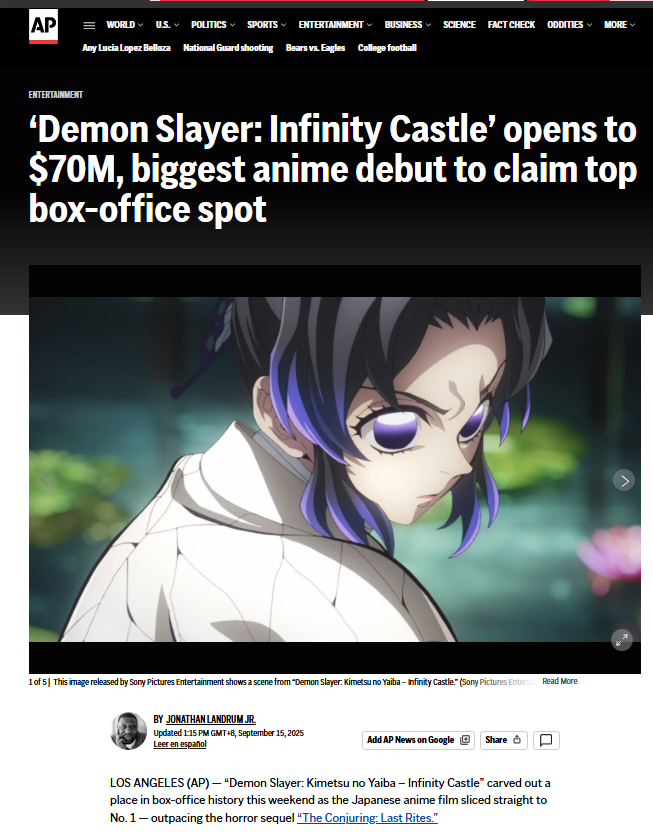

In [ ]:
# Answer here
url="https://apnews.com/article/demon-slayer-box-office-8937f757557c7b64b71d2074e64a2c5b"
# Create the retriever
retriever = load_and_retrieve_docs(url)

# Use the RAG chain
result = rag_chain(question="What was the U.S. opening weekend gross for ‘Demon Slayer: Infinity Castle’, and what record did it set?", retriever=retriever)
display(Markdown(result))

---
### <a id='toc1_5_10_'></a>[**2.6 Few-Shot Prompting Classification:**](#toc0_)

Few-shot prompting is a technique where a Large Language Model (LLM) is given a small number of labeled examples within a prompt to guide its classification. This allows the model to perform a new task with minimal data, avoiding the need for extensive fine-tuning.

In this lab, we will use the Gemini API to perform zero-shot, 1-shot, and 5-shot emotion classification:

*   **Zero-shot:** The model classifies text without any prior examples.
*   **1-shot:** The model is given one example for each emotion before classifying.
*   **5-shot:** The model is given five examples per emotion for better context.

To make our implementation robust and efficient, we are incorporating two key features:

1.  **Structured Output:** We provide the Gemini model with a specific output schema (`Emotions` class). This instructs the model to return *only* a valid emotion label (e.g., `joy`), which makes the output predictable and reliable, minimizing errors.
2.  **API Rate Handling:** The code includes a function to manage the requests-per-minute limit of the Gemini API.

We will test the model's performance on a small sample of 20 texts per emotion to ensure the process runs quickly. If the model provides an invalid response, the code will automatically retry the request until a valid classification is received.

少量範例提示（Few-shot prompting） 是一種技巧：在提示詞中放入少量已標註的範例，來引導大型語言模型（LLM）進行分類。這讓模型只需極少資料就能執行新任務，而不必進行大量微調。

在本實驗中，我們將使用 Gemini API 進行情緒分類的 zero-shot、1-shot 與 5-shot：
1. Zero-shot： 不提供任何範例，直接讓模型進行分類。
2. 1-shot： 在分類前，為每一種情緒各提供一個範例。
3. 5-shot： 在分類前，為每一種情緒各提供五個範例，以提供更完整的脈絡。

為了讓實作更穩健且高效，我們納入兩項關鍵設計：
- 結構化輸出（Structured Output）： 我們提供 Gemini 一個明確的輸出綱要（Emotions 類別）。這會指示模型只回傳有效的情緒標籤（例如 joy），讓輸出可預期且可靠，並將錯誤降到最低。
- API 速率控管： 程式碼包含一個函式，用來處理 Gemini API 每分鐘請求次數的限制。

我們會在每種情緒各取 20 筆的小樣本上測試模型效能，以確保流程能快速完成。若模型回傳了無效回覆，程式會自動重新送出請求，直到取得有效的分類結果為止。

**Prompt Structure:**
`System Instruction -> Task Description -> Examples (if not zero-shot) -> Text to Classify`


<span style="color:green">For the exercises in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

In [ ]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import enum
import os
from tqdm import tqdm
import json
import time
# Define the emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness']
# Define the model to use for few-shot prompting

# Schema for the output, the type enum can be used to make a pool of options if what we want is to classify our text selecting only one of them
class Emotions(enum.StrEnum):
    ANGER = 'anger'
    FEAR = 'fear'
    JOY = 'joy'
    SADNESS = 'sadness'


# Function to handle the rate limits of gemini models
def handle_rate_limit(request_count, first_request_time, max_calls_per_min):
    current_time = time.time()

    # Initialize timer on the first request of a new window
    if request_count == 0:
        first_request_time = current_time

    request_count += 1

    # If the rate limit is reached
    if request_count > max_calls_per_min:
        elapsed_time = current_time - first_request_time
        if elapsed_time < 60:
            wait_time = 60 - elapsed_time
            print(f"Rate limit of {max_calls_per_min} requests per minute reached. Waiting for {wait_time:.2f} seconds.")
            time.sleep(wait_time)

        # Reset for the new window
        request_count = 1
        first_request_time = time.time()

    return request_count, first_request_time, max_calls_per_min

# Function to sample examples per emotion category
def sample_few_shots(df, emotions, num_samples=5):
    few_shot_examples = {}
    for emotion in emotions:
        few_shot_examples[emotion] = df[df['emotion'] == emotion].sample(n=num_samples, random_state=42)
    return few_shot_examples

# Function to build the prompt based on the number of examples (few-shot, 1-shot, zero-shot)
def build_prompt(examples, emotions, num_shots=5):
    classification_instructions = """
You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories:
"anger" | "fear" | "joy" | "sadness"
    """

    prompt = classification_instructions + "\n\n"

    if num_shots > 0:
        prompt += f"Examples: \n"
        for emotion in emotions:
            for _, row in examples[emotion].iterrows():
                prompt += f"Text: {row['text']}\nClass: {emotion}\n\n" #Show the examples in the same format it will be shown for the classification text
                if num_shots == 1:  # If 1-shot, break after the first example for each emotion
                    break
    return prompt

# Function to classify using the LLM with retry for incorrect responses
def classify_with_llm(test_text, prompt_base, system_prompt, classes, schema):
    response = None
    while not response or response not in classes:
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nClass: " #The classification text will leave the emotion label to be filled in by the LLM
        try:
            result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt)
            # print(f"result: {result} \n")
            # print(f"type: {type(result)}")
            if not result:
                # In case of giving empty responses with temperature 0.0, we set a higher temperature to seek for different responses
                result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt, temperature=1.0)

            try:
                # If the result is in the correct format it can be parsed using json
                response = json.load(result)
            except:
                # In case it's not in a json friendly format
                # Deleting characters " and ' in case they appear in our response with the class of the text
                response = result.replace('"', '')
                response = response.replace("'", "")


        # except exceptions.ResourceExhausted as e:
        except Exception as e:
            print(f"Waiting to retry... Error: {e}")
            time.sleep(15)
            print(f"test_text: {test_text}")
            return classify_with_llm(test_text, prompt_base, system_prompt, classes, schema) # Retry the request


        if response not in classes:  # Retry if not a valid response
            print(f"Invalid response: {response}. Asking for reclassification.")
    return response

# Main function to run the experiment with the option for zero-shot, 1-shot, or 5-shot prompting
def run_experiment(df_train, df_test, num_test_samples=5, num_shots=5):
    # Sample examples for few-shot prompting based on num_shots
    if num_shots > 0:
        few_shot_examples = sample_few_shots(df_train, emotions, num_samples=num_shots)
        prompt_base = build_prompt(few_shot_examples, emotions, num_shots=num_shots)
    else:
        prompt_base = build_prompt(None, emotions, num_shots=0)  # Zero-shot has no examples

    # System prompt for our classification model:
    system_prompt = "You are an emotion classification model for text data. Do not give empty responses, classify according to the list of possible classes."

    # Prepare to classify the test set
    results_data = []

    print(prompt_base)
    # Sample 20 examples per emotion for the test set to classify
    test_samples = sample_few_shots(df_test, emotions, num_samples=num_test_samples)

    # Variables to handle rate limit of gemini
    request_count = 0
    max_calls_per_min = 15 # Gemini 2.5 Flash Lite has this maximum set in the documentation
    first_request_time = None

    # Classify 20 test examples (5 from each category) and save predictions
    for emotion in emotions:
        for _, test_row in tqdm(test_samples[emotion].iterrows(), desc=f"Processing samples for emotion: {emotion}...", total=num_test_samples):
            test_text = test_row['text']
            request_count, first_request_time, max_calls_per_min = handle_rate_limit(request_count, first_request_time, max_calls_per_min)  # Check and handle rate limit before each API call
            predicted_emotion = classify_with_llm(test_text = test_text, prompt_base = prompt_base, system_prompt = system_prompt, classes = emotions, schema = Emotions)
            # Append the results data:
            results_data.append({
                    'text': test_text,
                    'true_emotion': emotion,
                    'predicted_emotion': predicted_emotion
                })

    # Create dataframe to save the results data
    results_df = pd.DataFrame(results_data)

    # Extract just the true and predicted labels for metrics calculations
    true_labels = results_df['true_emotion']
    predictions = results_df['predicted_emotion']

    output_dir = "./results/llm_classification_results"
    os.makedirs(output_dir, exist_ok=True)
    # Save the results
    filename = f"{output_dir}/results_samples_{num_test_samples}_shots_{num_shots}.csv"

    # Save the DataFrame to CSV
    results_df.to_csv(filename, index=False)
    print(f"\nResults saved to {filename}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    print(classification_report(y_true=true_labels, y_pred=predictions))

    # Plot confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=predictions)
    my_tags = ['anger', 'fear', 'joy', 'sadness']
    plot_confusion_matrix(cm, classes=my_tags, title=f'Confusion matrix for classification with \n{num_shots}-shot prompting')

**Important: The next part should take around 16 minutes to finish running due to API Rate Limits**

**Note:** You might see an `429 RESOURCE_EXHAUSTED` error when running the following code all at once, this is because the `current API Rate Limit handling cannot reliably find out how many requests we have left per minute` from cell to cell, there is no Gemini feature created for it to get the information from their servers. So, `if you don't want to see the error you can just wait 1 minute` after one cell finished processing. But `even if there is an error showing it is fine`, internally in the code `there is a retry that happens every 15 seconds` until we finish processing our sampled data. `The lab is designed to never reach the total rate limit per day quota.`

重要：接下來這一段因為 API 速率限制，跑完大約需要 16 分鐘。

注意： 一次執行下面所有程式碼時，你可能會看到 429 RESOURCE_EXHAUSTED 錯誤。原因是：目前的 API 速率控管做法無法在不同 Cell 間可靠地得知「本分鐘還剩幾次請求可用」，而 Gemini 也沒有提供可查詢該資訊的功能。因此，如果不想看到錯誤訊息，可以在每個 Cell 執行完後先等 1 分鐘。
不過，就算出現錯誤也沒關係；在程式內部每 15 秒會自動重試，直到把抽樣資料全數處理完為止。本實驗的設計不會觸及每日總配額（daily quota）的上限。

In [ ]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with zero-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=0)

In [ ]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 1-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=1)

In [ ]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 5-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=5)

---
##### <a id='toc1_5_10_1_1_'></a>[**>>> Exercise 6 (Take home):**](#toc0_)

Compare and discuss the overall results of the zero-shot, 1-shot and 5-shot classification.

In [ ]:
# Answer here
import pandas as pd
from pathlib import Path

base = Path("results/llm_classification_results")

df0 = pd.read_csv(base/"results_samples_20_shots_0.csv").assign(setting="zero")
df1 = pd.read_csv(base/"results_samples_20_shots_1.csv").assign(setting="one")
df5 = pd.read_csv(base/"results_samples_20_shots_5.csv").assign(setting="five")

# 期望欄位：id, text, true_emotion, pred_emotion
for df in [df0, df1, df5]:
    df["correct"] = (df["pred_emotion"].str.lower() == df["true_emotion"].str.lower())

# 合併成同一表
all_df = pd.concat([df0, df1, df5], ignore_index=True)

# (1) 輸出各設定整體表現
overall = all_df.groupby("setting")["correct"].mean().sort_index()
print("Accuracy by setting:\n", overall)

# (2) 觀察各情緒類別分段表現
by_cls = all_df.groupby(["setting","true_emotion"])["correct"].mean().unstack(0)
print(by_cls)

# (3) 比較「同一筆樣本」在不同設定之間的變化
pivot = all_df.pivot_table(index="id", columns="setting", values="correct", aggfunc="first")

# 若有改善：設定 zero=False 且 five=True 或 one=True
improved = pivot[(pivot.get("zero")==False) & (pivot.filter(items=["one","five"]).any(axis=1))].index
# 若都無改善：三者皆輸出 False
no_gain   = pivot[(pivot.fillna(False)==False).all(axis=1)].index
# 如果甚至變差的話：zero=True 但 one 或 five 任一變 False
got_worse = pivot[(pivot.get("zero")==True) & (pivot.filter(items=["one","five"]).any(axis=1)==False)].index

print("improved:", len(improved), "no_gain:", len(no_gain), "got_worse:", len(got_worse))

# 把具體案例列出來（各取幾筆輸出）
cases_improved = all_df[all_df["id"].isin(improved)].sort_values("id").head(10)
cases_no_gain  = all_df[all_df["id"].isin(no_gain)].sort_values("id").head(10)
cases_worse    = all_df[all_df["id"].isin(got_worse)].sort_values("id").head(10)

# 也可以嘗試觀察「混淆」的情況：將實際×預測（以下以 5-shot 為例）
cm5 = pd.crosstab(df5["true_emotion"], df5["pred_emotion"], normalize="index").round(3)
print(cm5)

---
##### <a id='toc1_5_10_1_2_'></a>[**>>> Exercise 7 (Take home):**](#toc0_)

**Case Study:** Check the results' files inside the `results/llm_classification_results` directory and find cases where the **text classification improves with more examples** (pred emotion is right with examples), **cases where it does not improve** (pred emotion always wrong) and **cases where the classification got worse with more examples** (pred emotion goes from right to wrong with examples). For this you need to load the results with pandas and handle the data using its dataframe functions. Discuss about the findings.

個案研究（Case Study）： 請查看 results/llm_classification_results 資料夾中的結果檔，並找出以下情況：隨著範例數增加而有改善（提供範例後預測情緒正確）、沒有改善（不論是否提供範例，預測始終錯誤），以及隨著範例數增加而變差（提供範例後由原本正確變成錯誤）。為此，你需要用 pandas 載入結果，並以 DataFrame 的各種函式進行資料處理。最後，請對你的發現進行討論。

In [ ]:
# Answer here
import pandas as pd

# 1. 載入結果
df_0_shot = pd.read_csv('results/llm_classification_results/results_samples_20_shots_0.csv')
df_1_shot = pd.read_csv('results/llm_classification_results/results_samples_20_shots_1.csv')
df_5_shot = pd.read_csv('results/llm_classification_results/results_samples_20_shots_5.csv')

# 2. 重新命名以利區分
df_0_shot = df_0_shot.rename(columns={'predicted_emotion': 'pred_0'})
df_1_shot = df_1_shot.rename(columns={'predicted_emotion': 'pred_1'})
df_5_shot = df_5_shot.rename(columns={'predicted_emotion': 'pred_5'})

# 3. 合併資料
df_combined = df_0_shot[['text', 'true_emotion', 'pred_0']].copy()
# 將 1-shot 和 5-shot 的預測結果合併進來
df_combined['pred_1'] = df_1_shot['pred_1']
df_combined['pred_5'] = df_5_shot['pred_5']

# 4. 判斷每個階段的預測是否正確 (True/False)
df_combined['correct_0'] = df_combined['pred_0'] == df_combined['true_emotion']
df_combined['correct_1'] = df_combined['pred_1'] == df_combined['true_emotion']
df_combined['correct_5'] = df_combined['pred_5'] == df_combined['true_emotion']

# 5. 根據邏輯篩選三種情況

# (A) 隨著範例數增加而改善 (Improved)
# 定義：0-shot 預測錯誤，但 5-shot 預測正確
improved_cases = df_combined[(~df_combined['correct_0']) & (df_combined['correct_5'])]

# (B) 沒有改善 (No Improvement)
# 定義：不論是否提供範例，預測始終錯誤 (也就是 0-shot, 1-shot, 5-shot 全錯)
no_improvement_cases = df_combined[
    (~df_combined['correct_0']) &
    (~df_combined['correct_1']) &
    (~df_combined['correct_5'])
]

# (C) 隨著範例數增加而變差 (Worsened)
# 定義：0-shot 原本正確，但 5-shot 變成錯誤
worsened_cases = df_combined[(df_combined['correct_0']) & (~df_combined['correct_5'])]

# 6. 輸出統計結果與範例
print(f"總筆數: {len(df_combined)}")
print(f"改善案例數 (Improved): {len(improved_cases)}")
print(f"沒改善案例數 (No Improvement): {len(no_improvement_cases)}")
print(f"變差案例數 (Worsened): {len(worsened_cases)}")

print("\n--- 改善範例 (前 3 筆) ---")
print(improved_cases[['text', 'true_emotion', 'pred_0', 'pred_5']].head(3))

print("\n--- 變差範例 (前 3 筆) ---")
print(worsened_cases[['text', 'true_emotion', 'pred_0', 'pred_5']].head(3))

#(1) 分析結果統計
在總共 80 筆測試資料中：
- 改善案例: 10 筆 (約 12.5%)
- 沒改善案例: 29 筆 (約 36.25%)
- 變差案例: 5 筆 (約 6.25%)

(其餘資料為始終正確或由錯變錯等等模式)

#(2) 案例發現與討論
1. **隨著範例數增加而改善 (Improved)：**
- 這類情況通常發生在文本包含「反諷」或是「關鍵字情緒不明顯」時。模型在沒有範例佐證時容易被表面的正向詞彙誤導，而範例則可以幫助模型學會關注更深層的語意。
- 案例 1:
  - 文本: **@TrussElise Obama must be fuming.. lol**
  - 真實情緒: anger (憤怒) -> 0-shot 預測: joy (誤判，被 "lol" 誤導了)
  - 5-shot 預測: anger (正確，成功捕捉到 "fuming")
  - 0-shot 模型看到 "lol" 第一時間判斷為開心，但透過 5-shot 的學習後，模型學會忽略句尾的語助詞，轉而關注重點："fuming"（冒煙/氣憤）這個核心的情緒詞。
- 案例 2:
  - 文本: **@CozanGaming that's what lisa asked before she started raging at me, 'can I call you?' heh**
  - 真實情緒: anger -> 0-shot 預測: joy (誤判，或許是被 "heh" 或 "call you" 誤導)
  - 5-shot 預測: anger (正確)
  - 同樣是語氣詞 "heh" 干擾了 0-shot 的判斷，但在進一步範例的輔助下，模型能夠正確識別出 "raging"（發怒）才是重點詞彙。

2. **沒有改善 (No Improvement)**
- 這類情況佔比最高，通常可能原因是文本本身非常模糊、其中包含大量非標準語法（如網路推文標籤等），或是情緒表達太含蓄，即使給了 5 個範例當作佐證，模型仍然無法抓到邏輯。
- 案例:
  - 文本: **Kik to trade, have fun or a conversation ... #kik #textme #bored**
  - 真實情緒: anger
  - 所有預測: joy
  - 這段文字看起來比較像是垃圾訊息或廣告內容，有 #fun, #textme 等標籤。真實情緒為 anger 可能是因為發文者的動機（比如無聊了)
  - 但是這對 LLM 來說太難推斷，單純增加幾個範例不足以讓模型理解這種人類特殊的心境。

3. **隨著範例數增加而變差 (Worsened)**
- 這是一個比較有趣的現象（Negative Transfer），原本模型靠直覺是對的，結果多了範例以後反而讓它「想太多」。
- 案例:
  - 文本: [ @HedgehogDylan ] *she would frown a bit, folding her arms* 'why is it that every time I'm in need of assistance someone expects a lil
  - 真實情緒: anger
  - 0-shot 預測: anger (正確)
  - 5-shot 預測: sadness (錯誤)
  - 0-shot 模型很直觀地將 "frown"（皺眉）和抱怨的語氣連結到憤怒情緒。結果到了5-shot 的模型卻將其改判為 sadness（悲傷）。
  - 這可能是因為在提供的 5 個範例中，包含了一些存在「皺眉」或「身體動作描述」時而被標記為悲傷的案例，導致模型過度類化（Over-generalization），誤以為這種描述風格都屬於悲傷。

#(3) 總結討論
- 從數據來看，Few-shot Learning（少樣本學習）整體上是**利大於弊**的（改善 10 例 vs 變差 5 例）。
- **校正語氣**: 範例能有效幫助模型忽略 "lol", "heh" 等干擾詞，專注於真正的負面情緒詞（如 fuming, raging）。
- **範例存在雙面刃**: 但是我們要注意的是，變差的案例在提醒著我們，如果範例中的特徵與測試資料相似但情緒不同，可能會導致模型誤導，造成正確的直覺反而被翻篇的情況。
  - 這間接顯示了範例的選擇（Selection of Shots）對模型的表現也是至關重要的！

---
### <a id='toc1_5_11_'></a>[**2.7 Extra LLM Related Materials:**](#toc0_)
So this will be it for the lab, but here are some extra materials if you would like to explore:

- **How to use OpenAI ChatGPT model's API (Not Free API):** [Basics Video](https://www.youtube.com/watch?v=e9P7FLi5Zy8), [Basics GitHub](https://github.com/gkamradt/langchain-tutorials/blob/main/chatapi/ChatAPI%20%2B%20LangChain%20Basics.ipynb), [RAG's Basics Video](https://www.youtube.com/watch?v=9AXP7tCI9PI&t=300s), [RAG's Basics GitHub](https://github.com/techleadhd/chatgpt-retrieval)

- **Advanced topic - QLoRA (Quantized Low-Rank Adapter):** QLoRA is a method used to make fine-tuning large language models more efficient. It works by adding a small, trainable part (LoRA) to a pre-trained model, while keeping the rest of the model frozen. At the same time, it reduces the size of the model’s data using a process called quantization, which makes the model require less memory. This allows you to fine-tune large models without needing as much computational power, making it easier to adapt models for specific tasks. Materials: [Paper GitHub](https://github.com/artidoro/qlora?tab=readme-ov-file), [Llama 3 Application Video](https://www.youtube.com/watch?v=YJNbgusTSF0&t=512s),[Llama 3 Application GitHub](https://github.com/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb)

- **How to Fine-tune and run local LLMs with the `unsloth` library:** [unsloth tutorials](https://docs.unsloth.ai/models/tutorials-how-to-fine-tune-and-run-llms)

- **Google's Agent Development Kit Documentation:** [ADK](https://google.github.io/adk-docs/)

- **Build AI agents with LangGraph:** [LangGraph Documentation](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)

---